Data Mining: Basic Concepts - WS'19/20 
---------------
``` 
> University of Konstanz 
> Department of Computer and Information Science
> Dr. Johannes Fuchs, Eren Cakmak, Frederik Dennig
```

---

#### Exercise 1:  K-means  - _(5 Points)_

Perform k-means clustering with k=3 using the Euclidean distance by hand. Assume that initial clusters centroids are:

* Cluster 1: Record # 2
* Cluster 2: Record # 3
* Cluster 3: Record # 9

Compute for every iteration the updated cluster prototypes and state to which cluster each point is assigned after each iteration. 

_Note: In this exercise, you don’t need to normalize the data._

|ID|X1|X2|X3|X4|X5|
|-----|--------|-----------|-----------------|--------------|----|
|1|0.12|0.23|0.18|0.30|0.25|
|2|0.92|0.80|0.70|0.60|0.61|
|3|0.10|0.16|0.15|0.28|0.31|
|4|0.91|0.83|0.81|0.55|0.46|
|5|0.51|0.29|0.37|0.54|0.69|
|6|0.50|0.21|0.34|0.61|0.61|
|7|0.90|0.85|0.75|0.60|0.63|
|8|0.18|0.23|0.12|0.25|0.26|
|9|0.44|0.25|0.35|0.59|0.64|
|10|0.58|0.26|0.38|0.60|0.65|

![](Graphs/Ass06_kMeans.gif)

---

#### Exercise 2: Partitioning Around Medoids (PAM)  - _(10 Points)_ 

Load the `USArrests.csv` dataset and the following methods which can be used to compute PAM. Please install the `pyclustering` package. 

_(Hint: Use only the following imports)_

In [1]:
import pandas as pd
import numpy as np
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import pdist, cdist, squareform
import matplotlib.pyplot as plt
from random import randrange

In [2]:
df = pd.read_csv('Data/USArrests.csv')
df.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


##### __(a) Standardize the columns of the "USArrests" dataset. Explain why we have to standardize the dataset?__

In [3]:
def standardize(df):
    cols = list(df)
    for col in cols:
        if df[col].dtypes == np.float64 or df[col].dtypes == np.int64:
            col_mean = df[col].mean()
            col_std = df[col].std()
            df[col] = (df[col]-col_mean)/col_std
            print('Mean   {0:10s}{1:7.4f}'.format(col, round(df[col].mean(),5)))
            print('StdDev {0:10s}{1:7.4f}\n'.format(col, round(df[col].std(),5)))
    return(df)

df_std = standardize(df)

# We have to standardize the dataset because not every unit/variable is measured in the same scale
# standardizing these to mean 0 and stddev 1 leads to the information being comparable to each other

Mean   Murder    -0.0000
StdDev Murder     1.0000

Mean   Assault    0.0000
StdDev Assault    1.0000

Mean   UrbanPop  -0.0000
StdDev UrbanPop   1.0000

Mean   Rape       0.0000
StdDev Rape       1.0000



##### __(b) Compute the PAM (`kmedoids`) using `k = 3`. List the cluster and cluster medoids. Describe and explain the results.__

In [4]:
# Drop state due to no usefull information contained
df.drop(columns=['State'], inplace=True)

# Convert dataframe to array (for PAM)
x = df.to_numpy()
# Have a header-view of the "new" data
x[0:5]

array([[ 1.24256408,  0.78283935, -0.52090661, -0.00341647],
       [ 0.50786248,  1.10682252, -1.21176419,  2.48420294],
       [ 0.07163341,  1.47880321,  0.99898006,  1.04287839],
       [ 0.23234938,  0.23086801, -1.07359268, -0.1849166 ],
       [ 0.27826823,  1.26281442,  1.7589234 ,  2.06782029]])

In [5]:
# Set k
k = 3

# Choose k random medoids from the data (seed for reproducibility)
np.random.seed(0)
random_initial_medoids = np.random.randint(0,len(x),k)

# Initialize kmedoids with data and random starting points
pam = kmedoids(x, initial_index_medoids=random_initial_medoids)
pam.process()

# Show results of clustering
clusters = pam.get_clusters()
for i, cluster in zip(range(3), clusters):
    print('Cluster {}: {}'.format(i+1, cluster))

# Show medoids representative for each of the k clusters
medoids = pam.get_medoids()
print(medoids)

# Shown below are the three clusters, the list contain the represent the data point (by index)
# from the data. The first entries, as well displayed in the medoids, are the central medoids 
# used as an anchorpoint / distance-minimizing datapoint for each cluster.

Cluster 1: [40, 11, 14, 18, 25, 28, 33, 44, 47]
Cluster 2: [15, 3, 6, 7, 10, 13, 16, 20, 22, 26, 29, 34, 35, 36, 37, 38, 43, 45, 46, 48, 49]
Cluster 3: [30, 0, 1, 2, 4, 5, 8, 9, 12, 17, 19, 21, 23, 24, 27, 31, 32, 39, 41, 42]
[40, 15, 30]


##### __(c) Define an Python method to compute the measure for the compactness of a PAM clustering. The parameters of the method is the data and the instance of the kmedoids class (`kmedoids_instance`).__

$$TD=\sum\limits^k_{i = 1} TD(C_i) \text{ and } TD(C) = \sum\limits_{p \in C} dist(p, m_c)$$

The medoid $m_c$ is the representative element of the cluster. 

_(Hint: Use the `pdist` or `cdist` method to compute the pairwise distance between $p$ and $m_c$)_

In [6]:
def tdc(data, model, output=True):
    """Compute total distances (TD as well as TD(C)) for PAM clustering.
    The higher the distances, the less compact the cluster(ing).
    
    Input:
      data:   Array of data (as for pyclustering.cluster.kmedoids)
      model:  The already initialized and processed model of kmedoids
      output: Print intermediate results while calculating, default=True
    
    Returns:
      cluster_distances: List of distances from each cluster's data point to
                         its respective medoid (for each cluster as arrays)
                         = TD(C)
      td:                Sum of all distances, measures compactness
                         = TD
     
    """
    clusters = model.get_clusters()
    
    td = 0
    cluster_distances = []
    for i, cluster in zip(range(len(medoids)), clusters):
        cluster_distances.append(cdist(data[cluster], data[cluster][[0]]))
        td = td + cluster_distances[i].sum()
        if output:
            print('Cluster {}\nData:  {}\ncdist:  {}\n'.format(i+1,
                                                               cluster,
                                                               round(cluster_distances[i].sum(),2)))
    return(cluster_distances, td)

cluster_distances, td = tdc(x, pam)

Cluster 1
Data:  [40, 11, 14, 18, 25, 28, 33, 44, 47]
cdist:  7.28

Cluster 2
Data:  [15, 3, 6, 7, 10, 13, 16, 20, 22, 26, 29, 34, 35, 36, 37, 38, 43, 45, 46, 48, 49]
cdist:  22.74

Cluster 3
Data:  [30, 0, 1, 2, 4, 5, 8, 9, 12, 17, 19, 21, 23, 24, 27, 31, 32, 39, 41, 42]
cdist:  29.84



##### __(d) Use the newly defined function to compute TD of PAM $k = 3$.__

In [7]:
k = 3
np.random.seed(0)
random_initial_medoids = np.random.randint(0,len(x),k)

pam = kmedoids(x, initial_index_medoids=random_initial_medoids)
pam.process()

cluster_distances, td = tdc(x, pam, output=False)
print(td)

59.863704584976475


##### __(e) Compute the TD's for PAM with $k = 1, \dots, 10$ and plot the results. Explain the results of the plot.__

In [8]:
list_of_k = list(range(1,11))
list_of_td = []

print(' k | Total Distance\n---+---------------')
for k in list_of_k:
    np.random.seed(0)
    random_initial_medoids = np.random.randint(0,len(x),k)
    pam = kmedoids(x, initial_index_medoids=random_initial_medoids)
    pam.process()
    cluster_distances, td = tdc(x, pam, output=False)
    list_of_td.append(td)
    print('{:2} |  {:.5f}'.format(k, td))

 k | Total Distance
---+---------------
 1 |  92.99458
 2 |  73.05703
 3 |  59.86370
 4 |  34.50146
 5 |  20.40560
 6 |  20.40560
 7 |  9.82871
 8 |  7.72849
 9 |  7.72849
10 |  7.72849


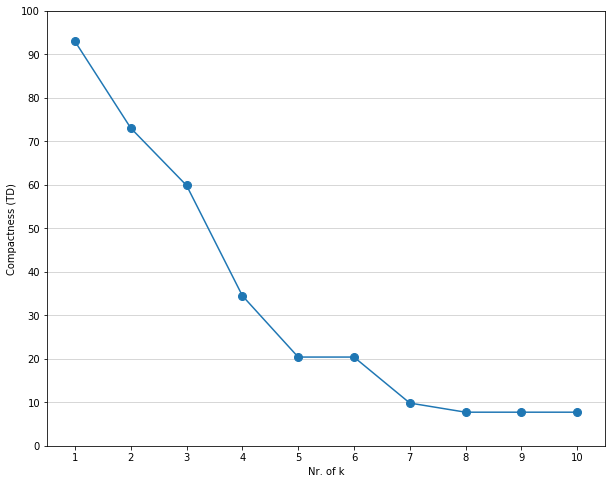

In [9]:
x = list_of_k
y = list_of_td

plt.figure(figsize=(10,8))
plt.plot(x, y, '-o', markersize=8)

plt.xlabel('Nr. of k')
plt.xlim(0.5,10.5)
plt.xticks(range(1,11))

plt.ylabel('Compactness (TD)')
plt.ylim(0,100)
plt.yticks(range(0,110,10))

plt.grid(axis='y', linewidth=0.5)

plt.show()

> **Interpretation**
>  
> As k increases, the clustering becomes more compact.  
> Important to mention is that this relationship is not of linear nature!  
> Instead, there is a near-linear decrease in TD from k=1 to k=5, no change afterwards and 
> only a small drop between k=6 and k=7 again. Further increasing k does not change TD.  
>  
> This can be interpreted as follows: with each addition medoid/cluster used, the compactness of
> the clustering increases until it stops optimizing at k=5. Therefore, I would suggest to 
> assume 5 clusters in this data, even though 7 might be an acceptable alternative as well.  
> More clusters should not be build!

---

#### Exercise 3: Expectation Maximization (EM) Algorithm  - _(5 Points)_ 

The sklearn class `GaussianMixture`can be used to compute the EM algorithm. 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture

##### __(a) Cluster the `em-data.csv` data. Describe each step and reason your parameter choices.__

Mean   d0        -0.0000
StdDev d0         1.0000

Mean   d1         0.0000
StdDev d1         1.0000



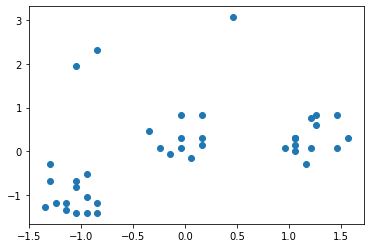

In [11]:
# Read the Data
df = pd.read_csv('Data/em-data.csv')

# Standardize the Data
df = standardize(df)

# Plot the data
plt.scatter(x=df['d0'],
            y=df['d1'])
plt.show()

> **These are obviously three _"real"_ clusters with a little bit of noise around**

In [12]:
# Random State for Reproducibility, n_components=3 because it should detect 3 clusters
gmc = GaussianMixture(n_components=3, random_state=1).fit(df)
# Shows cluster for each data point
cluster3 = gmc.predict(df)
print(cluster3)

# Noise might have an influence on clustering, try again with 4 clusters
# (3 clusters + noise, random_state still 1)
gmc = GaussianMixture(n_components=4, random_state=1).fit(df)
# Shows cluster for each data point
cluster4 = gmc.predict(df)
print(cluster4)

[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1
 0 2 2 2]
[3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 1 1 3 0 0 0 3 3 3 3 3 3 1 1 1 1 1 1 1 3 0 0
 3 2 2 2]


##### __(b) Visualize your results in a 2D plot.__

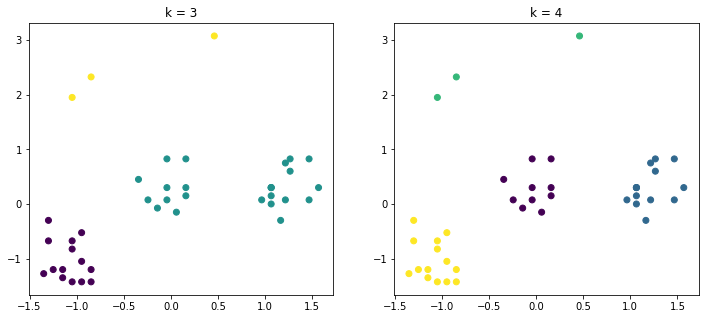

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.title('k = 3')
plt.scatter(x=df['d0'],
            y=df['d1'],
            c=cluster3)

plt.subplot(122)
plt.title('k = 4')
plt.scatter(x=df['d0'],
            y=df['d1'],
            c=cluster4)
plt.show()

> **In this case, k=4 should be preferred.  
> It handles the noise as a separate cluster and therefore identifies the remaining three clusters correct**

---